In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/content/india_air_quality_data.csv",encoding='ISO-8859-1')

x = data["no2"].dropna().values
x = x[x < np.percentile(x, 99)]

/tmp/ipython-input-2112707655.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/content/india_air_quality_data.csv",encoding='ISO-8859-1')


In [3]:
r = 102317042
a = 0.5 * (r % 7)
b = 0.3 * ((r % 5) + 1)
z = x + a * np.sin(b * x)
z = torch.tensor(z, dtype=torch.float32).view(-1, 1)

In [4]:
G = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)

D = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)


In [5]:
loss_fn = nn.BCELoss()
g_opt = optim.Adam(G.parameters(), lr=0.001)
d_opt = optim.Adam(D.parameters(), lr=0.001)

epochs = 2500
batch = 32

In [6]:
for e in range(epochs):

    idx = torch.randint(0, z.size(0), (batch,))
    real = z[idx]

    real_lbl = torch.ones(batch, 1)
    fake_lbl = torch.zeros(batch, 1)

    # train discriminator
    noise = torch.randn(batch, 1)
    fake = G(noise)

    d_real = D(real)
    d_fake = D(fake.detach())

    d_loss = loss_fn(d_real, real_lbl) + loss_fn(d_fake, fake_lbl)

    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()

    # train generator
    noise = torch.randn(batch, 1)
    fake = G(noise)

    g_loss = loss_fn(D(fake), real_lbl)

    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

    if e % 500 == 0:
        print("epoch:", e, "D loss:", d_loss.item(), "G loss:", g_loss.item())

epoch: 0 D loss: 1.0839588642120361 G loss: 0.5784614682197571
epoch: 500 D loss: 0.6541569232940674 G loss: 1.3342032432556152
epoch: 1000 D loss: 1.5021076202392578 G loss: 0.844184398651123
epoch: 1500 D loss: 1.3933955430984497 G loss: 0.771708071231842
epoch: 2000 D loss: 1.397226095199585 G loss: 0.7181045413017273


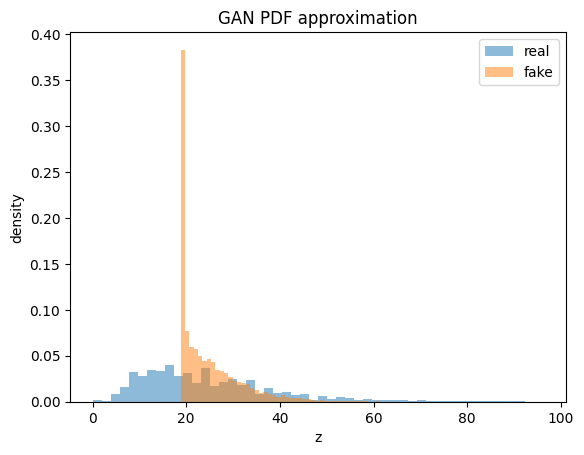

In [7]:
noise = torch.randn(8000, 1)
gen_z = G(noise).detach().numpy()

plt.hist(z.numpy(), bins=50, density=True, alpha=0.5, label="real")
plt.hist(gen_z, bins=50, density=True, alpha=0.5, label="fake")
plt.legend()
plt.xlabel("z")
plt.ylabel("density")
plt.title("GAN PDF approximation")
plt.show()